<a href="https://colab.research.google.com/github/syedokun/HAD7001/blob/main/Project/Project_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive mounting and importing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
demo = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/demo.csv')
encDx = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/encDx.csv')
encounters = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/encounters.csv')
health = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/health.csv')
lab = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/lab.csv')
medication = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/medication.csv')
medproc = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/medproc.csv')
patient = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/patient.csv', sep=';')
risk = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/risk.csv')

## EDA and master_df generation

In [ ]:
master_df = patient.drop_duplicates(subset=['Patient_ID'], keep='first')
master_df = master_df.drop(columns=['BirthMonth', 'OptedOut', 'OptOutDate'], errors='ignore')

In [ ]:
risk = risk[pd.to_numeric(risk['Patient_ID'], errors='coerce').notnull()]
risk['Patient_ID'] = risk['Patient_ID'].astype(int)
risk_grouped = risk.groupby('Patient_ID').agg(
    {'Name_calc': list, 'Name_orig': list}
).reset_index()
master_df = pd.merge(master_df, risk_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={
    'Name_calc': 'Risks',
    'Name_orig': 'Risks_orig'
    })

In [ ]:
def remove_duplicates_from_list(x):
  if isinstance(x, list):
    return list(set(x))
  else:
    return x

master_df['Risk_List'] = master_df['Risks'].apply(remove_duplicates_from_list)

In [ ]:
def remove_nan_from_risks(row):
    risks = row['Risks']
    risks_orig = row['Risks_orig']

    if isinstance(risks, list) and isinstance(risks_orig, list):
        new_risks = []
        new_risk_orig = []
        for i in range(len(risks)):
            if not pd.isna(risks[i]):
                new_risks.append(risks[i])
                new_risk_orig.append(risks_orig[i])
        row['Risks'] = new_risks
        row['Risks_orig'] = new_risk_orig
    return row

master_df = master_df.apply(remove_nan_from_risks, axis=1)

In [ ]:
import pandas as pd

def remove_nan_from_list(x):
  if isinstance(x, list):
    return [i for i in x if not pd.isna(i)]
  else:
    return x

master_df['Risk_List'] = master_df['Risk_List'].apply(remove_nan_from_list)


In [ ]:
medproc_grouped = medproc.groupby('Patient_ID').agg(
    {'Name_orig': list, 'PerformedDate': list}
).reset_index()

master_df = pd.merge(master_df, medproc_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={'Name_orig': 'MedProcs_List', 'PerformedDate': 'MedProcs_Date'})

In [ ]:
import pandas as pd
def remove_nan_from_medprocs(row):
    medprocs = row['MedProcs_List']
    dates = row['MedProcs_Date']

    if isinstance(medprocs, list) and isinstance(dates, list):
        new_medprocs = []
        new_dates = []
        for i in range(len(medprocs)):
            if not pd.isna(medprocs[i]):
                new_medprocs.append(medprocs[i])
                new_dates.append(dates[i])
        row['MedProcs_List'] = new_medprocs
        row['MedProcs_Date'] = new_dates
    return row

master_df = master_df.apply(remove_nan_from_medprocs, axis=1)


In [ ]:
import datetime

current_year = datetime.datetime.now().year
master_df['Age'] = current_year - master_df['BirthYear']

In [ ]:
# Convert StartDate and StopDate to datetime objects, handling errors
medication['StartDate'] = pd.to_datetime(medication['StartDate'], errors='coerce')
medication['StopDate'] = pd.to_datetime(medication['StopDate'], errors='coerce')

# Replace out-of-bounds dates with NaT (Not a Time)
medication.loc[medication['StopDate'].dt.year > 2262, 'StopDate'] = pd.NaT

# Calculate MedDuration
medication['MedDuration'] = (medication['StopDate'] - medication['StartDate']).dt.days

In [ ]:
# Convert 'StartDate' back to string
medication['StartDate'] = medication['StartDate'].dt.strftime('%Y-%m-%d')

In [ ]:
medication = medication[['Patient_ID', 'StartDate', 'Name_calc', 'MedDuration', 'Reason', 'Frequency', 'Strength', 'Dose', 'UnitOfMeasure']]

In [ ]:
medication_grouped = medication.groupby('Patient_ID').agg(
    {
        'StartDate': list,
        'Name_calc': list,
        'MedDuration': list,
        'Reason': list,
        'Frequency': list,
        'Strength': list,
        'Dose': list,
        'UnitOfMeasure': list,
    }
).reset_index()

master_df = pd.merge(master_df, medication_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={'StartDate': 'Med_Start_Dates',
                                      'Name_calc': 'Medications',
                                      'MedDuration': 'Med_Durations',
                                      'Reason': 'Med_Reasons',
                                      'Frequency': 'Med_Frequencies',
                                      'Strength': 'Med_Strengths',
                                      'Dose': 'Med_Doses',
                                      'UnitOfMeasure': 'Med_UnitOfMeasures',
                                      })

In [ ]:
def remove_nan_from_medications(row):
    medications = row['Medications']
    dates = row['Med_Start_Dates']
    durations = row['Med_Durations']
    reasons = row['Med_Reasons']
    frequencies = row['Med_Frequencies']
    strengths = row['Med_Strengths']
    doses = row['Med_Doses']
    units = row['Med_UnitOfMeasures']

    if isinstance(medications, list) and isinstance(dates, list) and isinstance(durations, list):
        new_medications = []
        new_dates = []
        new_durations = []
        new_reasons = []
        new_frequencies = []
        new_strengths = []
        new_doses = []
        new_units = []

        for i in range(len(medications)):
            if not pd.isna(medications[i]):
                new_medications.append(medications[i])
                new_dates.append(dates[i])
                new_durations.append(durations[i])
                new_reasons.append(reasons[i])
                new_frequencies.append(frequencies[i])
                new_strengths.append(strengths[i])
                new_doses.append(doses[i])
                new_units.append(units[i])

        row['Medications'] = new_medications
        row['Med_Start_Dates'] = new_dates
        row['Med_Durations'] = new_durations
        row['Med_Reasons'] = new_reasons
        row['Med_Frequencies'] = new_frequencies
        row['Med_Strengths'] = new_strengths
        row['Med_Doses'] = new_doses
        row['Med_UnitOfMeasures'] = new_units

    return row

master_df = master_df.apply(remove_nan_from_medications, axis=1)

In [ ]:
# Remove duplicate Patient_ID from demo df by taking the first one
demo = demo.drop_duplicates(subset=['Patient_ID'], keep='first')

In [ ]:
demo = demo[['Patient_ID', 'PatientStatus_calc', 'DeceasedYear']]

In [ ]:
# Update PatientStatus_calc based on DeceasedYear
demo.loc[demo['DeceasedYear'].notnull(), 'PatientStatus_calc'] = 'Deceased'

In [ ]:
master_df = pd.merge(master_df, demo, on='Patient_ID', how='left')

In [ ]:
# Recalculate Age based on DeceasedYear where it's not null
master_df.loc[master_df['DeceasedYear'].notnull(), 'Age'] = master_df.loc[master_df['DeceasedYear'].notnull(), 'DeceasedYear'] - master_df.loc[master_df['DeceasedYear'].notnull(), 'BirthYear']

In [ ]:
lab = lab[['Patient_ID', 'PerformedDate', 'Name_calc', 'TestResult_calc', 'UpperNormal', 'LowerNormal', 'NormalRange', 'UnitOfMeasure_calc']]

In [ ]:
lab_grouped = lab.groupby('Patient_ID').agg(
    {
        'PerformedDate': list,
        'Name_calc': list,
        'TestResult_calc': list,
        'UpperNormal': list,
        'LowerNormal': list,
        'NormalRange': list,
        'UnitOfMeasure_calc': list,
        }
).reset_index()

master_df = pd.merge(master_df, lab_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={
                                      'PerformedDate': 'Lab_Performed_Dates',
                                      'Name_calc': 'LabTests',
                                      'TestResult_calc': 'Lab_Test_Results',
                                      'UpperNormal': 'Lab_Upper_Normal',
                                      'LowerNormal': 'Lab_Lower_Normal',
                                      'NormalRange': 'Lab_Normal_Range',
                                      'UnitOfMeasure_calc': 'Lab_UnitOfMeasure',
                                      })

In [ ]:
def remove_nan_from_labs(row):
    labs = row['LabTests']
    dates = row['Lab_Performed_Dates']
    results = row['Lab_Test_Results']
    upper_normal = row['Lab_Upper_Normal']
    lower_normal = row['Lab_Lower_Normal']
    normal_range = row['Lab_Normal_Range']
    units = row['Lab_UnitOfMeasure']

    if isinstance(labs, list) and isinstance(dates, list) and isinstance(results, list):
        new_labs = []
        new_dates = []
        new_results = []
        new_upper_normal = []
        new_lower_normal = []
        new_normal_range = []
        new_units = []
        for i in range(len(labs)):
            if not pd.isna(labs[i]):
                new_labs.append(labs[i])
                new_dates.append(dates[i])
                new_results.append(results[i])
                new_upper_normal.append(upper_normal[i])
                new_lower_normal.append(lower_normal[i])
                new_normal_range.append(normal_range[i])
                new_units.append(units[i])
        row['LabTests'] = new_labs
        row['Lab_Performed_Dates'] = new_dates
        row['Lab_Test_Results'] = new_results
        row['Lab_Upper_Normal'] = new_upper_normal
        row['Lab_Lower_Normal'] = new_lower_normal
        row['Lab_Normal_Range'] = new_normal_range
        row['Lab_UnitOfMeasure'] = new_units
    return row

master_df = master_df.apply(remove_nan_from_labs, axis=1)

In [ ]:
health = health[['Patient_ID', 'Encounter_ID', 'DiagnosisCode_calc', 'DiagnosisText_calc', 'DateOfOnset']]

In [ ]:
health_grouped = health.groupby('Patient_ID').agg(
        {
        'Encounter_ID': list,
        'DiagnosisCode_calc': list,
        'DiagnosisText_calc': list,
        'DateOfOnset': list
        }
).reset_index()

master_df = pd.merge(master_df, health_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={'Encounter_ID': 'Health_condition_Encounter_IDs',
                                      'DiagnosisCode_calc': 'ICD-9',
                                      'DiagnosisText_calc': 'Overall_Diagnosis_List',
                                      'DateOfOnset': 'DateOfOnset_Overall_Diagnosis'})

In [ ]:
def remove_nan_from_health(row):
    encounters = row['Health_condition_Encounter_IDs']
    codes = row['ICD-9']
    texts = row['Overall_Diagnosis_List']
    dates = row['DateOfOnset_Overall_Diagnosis']

    if isinstance(texts, list):
        new_encounters = []
        new_codes = []
        new_texts = []
        new_dates = []
        for i in range(len(texts)):
            if not pd.isna(texts[i]):
                new_encounters.append(encounters[i])
                new_codes.append(codes[i])
                new_texts.append(texts[i])
                new_dates.append(dates[i])

        row['Health_condition_Encounter_IDs'] = new_encounters
        row['ICD-9'] = new_codes
        row['Overall_Diagnosis_List'] = new_texts
        row['DateOfOnset_Overall_Diagnosis'] = new_dates
    return row

master_df = master_df.apply(remove_nan_from_health, axis=1)

In [ ]:
master_df['Overall_Diagnosis'] = master_df['Overall_Diagnosis_List'].apply(remove_duplicates_from_list)
master_df['Overall_Diagnosis'] = master_df['Overall_Diagnosis'].apply(remove_nan_from_list)

In [ ]:
encDx = encDx[['Patient_ID', 'Encounter_ID', 'DiagnosisCode_calc', 'DiagnosisText_orig']]

In [ ]:
encounters = encounters[['Patient_ID', 'Encounter_ID', 'EncounterDate', 'Reason_orig']]

In [ ]:
encounters_df = pd.merge(encDx, encounters, on='Encounter_ID', how='left')

In [ ]:
# Filter out rows where Patient_ID_x and Patient_ID_y don't match
encounter_df = encounters_df[encounters_df['Patient_ID_x'] == encounters_df['Patient_ID_y']]

In [ ]:
encounter_df['Patient_ID'] = encounter_df['Patient_ID_x']
encounter_df = encounter_df.drop(columns=['Patient_ID_x', 'Patient_ID_y'])

In [ ]:
encounter_grouped = encounter_df.groupby('Patient_ID').agg(list).reset_index()

In [ ]:
master_df = pd.merge(master_df, encounter_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={'Encounter_ID': 'Encounter_IDs',
                                      'DiagnosisText_orig': 'EncounterDiagnosisTexts',
                                      'DiagnosisCode_calc': 'EncounterDiagnosisCodes',
                                      'EncounterDate': 'EncounterDates',
                                      'Reason_orig': 'EncounterReasonTexts'})

In [ ]:
master_df['Total_Risks'] = master_df['Risk_List'].apply(lambda x: len(x) if isinstance(x, list) else 0)
master_df['Total_Encounters'] = master_df['EncounterDates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
master_df['Total_Medications'] = master_df['Medications'].apply(lambda x: len(x) if isinstance(x, list) else 0)
master_df['Total_LabTests'] = master_df['Lab_Performed_Dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
master_df['Total_MedProcs'] = master_df['MedProcs_List'].apply(lambda x: len(x) if isinstance(x, list) else 0)
master_df['Total_Overall_Diagnoses'] = master_df['Overall_Diagnosis'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [ ]:
new_column_order = ['Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age', 'PatientStatus_calc',
                    'Total_Overall_Diagnoses', 'Overall_Diagnosis', 'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis', 'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks',
                    'Risk_List', 'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates', 'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes',
                    'EncounterReasonTexts', 'Total_Medications', 'Medications', 'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies', 'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures',
                    'Total_LabTests', 'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results', 'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range', 'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List', 'MedProcs_Date']

master_df = master_df[new_column_order]

In [ ]:
def clean_dates(date_list):
    if isinstance(date_list, list):
        return [date_str[:10] if isinstance(date_str, str) else date_str for date_str in date_list]
    return date_list

In [ ]:
master_df['EncounterDates'] = master_df['EncounterDates'].apply(clean_dates)
master_df['Lab_Performed_Dates'] = master_df['Lab_Performed_Dates'].apply(clean_dates)

In [ ]:
master_df['Sex'] = master_df['Sex'].replace({'MALE': 'Male', 'FEMALE': 'Female'})

### Chronic diseases

In [ ]:
chronic_diseases_as_icd_codes = ["PARKINSON'S DISEASE", "DEMENTIAS", "DEPRESSIVE DISORDER, NOT ELSEWHERE CLASSIFIED"]
chronic_diseases_as_diagnoses_text = ["asthma", "diabetes", "hypertension", "copd"]

In [ ]:
# icd9_df = pd.read_csv('/content/drive/MyDrive/Research/Care4minds/Dataset v1/ICD9_df.csv')
# icd9_df

In [ ]:
import pandas as pd

chronic_diseases_as_icd_codes_lower = [disease.lower() for disease in chronic_diseases_as_icd_codes]
chronic_patients = health[health['DiagnosisText_calc'].str.lower().isin(chronic_diseases_as_icd_codes_lower)]
chronic_df = chronic_patients[['Patient_ID', 'DiagnosisText_calc']]
chronic_df = chronic_df.rename(columns={'DiagnosisText_calc': 'disease'})
chronic_df = chronic_df.replace(["PARKINSON'S DISEASE", "DEMENTIAS", "DEPRESSIVE DISORDER, NOT ELSEWHERE CLASSIFIED"], ["parkinsons", "dementia", "depression"])

chronic_df

In [ ]:
import pandas as pd

def find_chronic_matches(encDx, chronic_diseases):
    """
    Finds matches between diagnosis text and a list of chronic diseases.

    Args:
        encDx: DataFrame with a 'DiagnosisText_orig' column.
        chronic_diseases: A list of chronic disease terms.

    Returns:
         A new DataFrame with matching Patient_ID and diagnosis text.
    """
    matches_df = pd.DataFrame(columns=['Patient_ID', 'Matching_Word'])
    for index, row in encDx.iterrows():
      if pd.isna(row["DiagnosisText_orig"]):
          continue
      diagnosis_text = str(row['DiagnosisText_orig']).lower()
      for disease in chronic_diseases:
          if disease.lower() in diagnosis_text:
              matches_df = pd.concat([matches_df, pd.DataFrame({'Patient_ID': [row['Patient_ID']], 'Matching_Word': [disease]})], ignore_index=True)
              break  # Avoid multiple matches for the same disease in the same row

    return matches_df

chronic_matches = find_chronic_matches(encDx, chronic_diseases_as_diagnoses_text)
chronic_matches = chronic_matches.rename(columns={'Matching_Word': 'disease'})
chronic_matches

In [ ]:
chronic_combined_df = pd.concat([chronic_matches, chronic_df], axis=0, ignore_index=True)
chronic_combined_df

In [ ]:
chronic_diseases_master_df = chronic_combined_df.groupby('Patient_ID')['disease'].apply(list).reset_index()

# Remove duplicates from the 'disease' column in chronic_diseases_master_df
chronic_diseases_master_df['disease'] = chronic_diseases_master_df['disease'].apply(lambda x: list(set(x)))

In [ ]:
chronic_diseases_master_df.to_pickle('/Users/syedokun/Downloads/Research/LLM in MH/Care4minds/V 3.0 Dataset/pkl/chronic_diseases_master_df.pkl')

In [ ]:
master_df = pd.merge(master_df, chronic_diseases_master_df, on='Patient_ID', how='left')

In [ ]:
master_df = master_df.rename(columns={'disease': 'Chronic_diseases'})

In [ ]:
def convert_to_list(x):
  try:
    return eval(x) if isinstance(x, str) else x
  except (SyntaxError, NameError):
    return []  # Return an empty list if evaluation fails

master_df['Chronic_diseases'] = master_df['Chronic_diseases'].apply(convert_to_list)

In [ ]:
master_df['Total_Chronic_diseases'] = master_df['Chronic_diseases'].apply(lambda x: len(x) if isinstance(x, list) else 0)

### Adding grouped diagnoses and medications

In [ ]:
grouped_medications = pd.read_csv("/Users/syedokun/Downloads/Research/LLM in MH/Care4minds/V 3.0 Dataset/csv/medications_cleaned_grouped.csv")
grouped_diagnoses = pd.read_csv("/Users/syedokun/Downloads/Research/LLM in MH/Care4minds/V 3.0 Dataset/csv/mh_diagnoses_cleaned_grouped.csv")

In [ ]:
def group_diagnoses(diagnosis_list, mapping_df):
    grouped_diagnoses = []
    if isinstance(diagnosis_list, list):
        for diagnosis in diagnosis_list:
            matching_group = mapping_df[mapping_df['DiagnosisText_calc'] == diagnosis]['DSM5_group']
            if not matching_group.empty:
                grouped_diagnoses.append(matching_group.iloc[0])
            else:
              grouped_diagnoses.append(diagnosis) # Keep original diagnosis if no match is found
    return grouped_diagnoses

master_df['Grouped_Overall_Diagnosis'] = master_df['Overall_Diagnosis'].apply(lambda x: group_diagnoses(x, grouped_diagnoses))


In [ ]:
master_df['Grouped_Overall_Diagnosis'] = master_df['Grouped_Overall_Diagnosis'].apply(remove_duplicates_from_list)

In [ ]:
def group_medications(medication_list, mapping_df):
    grouped_medications = []
    if isinstance(medication_list, list):
        for medication in medication_list:
            matching_group = mapping_df[mapping_df['Name_calc'] == medication]['medication_group']
            if not matching_group.empty:
                grouped_medications.append(matching_group.iloc[0])
            else:
              grouped_medications.append(medication) # Keep original medication if no match is found
    return grouped_medications

master_df['Grouped_Medications'] = master_df['Medications'].apply(lambda x: group_medications(x, grouped_medications))

In [ ]:
master_df['Grouped_Medications_Set'] = master_df['Grouped_Medications'].apply(remove_duplicates_from_list)

### Cleaning up risk

In [ ]:
risk_cleaned = risk[risk['Status_orig'] != 'Never']

In [ ]:
risk_cleaned = risk_cleaned[pd.to_numeric(risk_cleaned['Patient_ID'], errors='coerce').notnull()]
risk_cleaned['Patient_ID'] = risk_cleaned['Patient_ID'].astype(int)

risk_cleaned_grouped = risk_cleaned.groupby('Patient_ID').agg(
    {'Name_calc': list}
).reset_index()
master_df = pd.merge(master_df, risk_cleaned_grouped, on='Patient_ID', how='left')
master_df = master_df.rename(columns={
    'Name_calc': 'Risks_cleaned'
    })

In [ ]:
master_df['Risk_cleaned_List'] = master_df['Risks_cleaned'].apply(remove_duplicates_from_list)
master_df['Risk_cleaned_List'] = master_df['Risk_cleaned_List'].apply(remove_nan_from_list)

### Calculate event frequency columns

In [ ]:
import pandas as pd

def calculate_event_frequency(master_df, date_column, events_column):
    """
    Calculates the monthly frequency of events based on a date range and total events.

    Args:
        master_df: DataFrame containing the data.
        date_column: Name of the column with a list of dates.
        events_column: Name of the column with the total number of events.

    Returns:
        DataFrame with an added 'Frequency_per_month' column.
    """

    def calculate_frequency(dates, total_events):
        if not isinstance(dates, list) or not dates or total_events is None:
          return None

        try:
            # Convert dates to datetime objects before calculating min/max
            dates = [pd.to_datetime(d) for d in dates if isinstance(d, str)]
            if not dates:
                return None

            start_date = min(dates)
            end_date = max(dates)

            time_delta = end_date - start_date
            months = time_delta.days / 30

            if months == 0:
                return 0

            return total_events / months
        except Exception as e:
            print("Error converting dates or calculating frequency.")
            return None

    frequency_per_month_column = master_df.apply(lambda row: calculate_frequency(row[date_column], row[events_column]), axis=1)
    return frequency_per_month_column

In [ ]:
master_df["Encounter_frequency_per_month"] = calculate_event_frequency(master_df, 'EncounterDates', 'Total_Encounters')
master_df["Medication_frequency_per_month"] = calculate_event_frequency(master_df, 'Med_Start_Dates', 'Total_Medications')
master_df["Lab_frequency_per_month"] = calculate_event_frequency(master_df, 'Lab_Performed_Dates', 'Total_LabTests')
master_df["Medproc_frequency_per_month"] = calculate_event_frequency(master_df, 'MedProcs_Date', 'Total_MedProcs')

## Export

In [ ]:
master_df.to_pickle('/content/drive/MyDrive/Research/Care4minds/Dataset v1/master_df_multiple_diagnoses.pkl')

## Environment setup

In [1]:
!pip install numpy --upgrade

# Restart session before this
import numpy as np
print(np.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you have numpy 2.2.3 which is incompatible.
langchain 0.3.18 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 2.2.3 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
pytenso

In [1]:
import numpy as np
import pandas as pd

print(np.__version__)

2.2.3


In [3]:
import pandas as pd
import numpy as np

master_df = pd.read_pickle('/content/drive/MyDrive/Research/Care4minds/Dataset v3/master_df.pkl')

## Predicting Mental Health vs Non Mental Health patients

In [4]:
master_df.describe()

,Patient_ID,BirthYear,DeceasedYear,Age,Total_Overall_Diagnoses,Total_Risks,Total_Encounters,Total_Medications,Total_LabTests,Total_MedProcs,Total_Chronic_diseases,Total_MH_diagnoses,percentage_of_MH_diagnoses,Encounter_frequency_per_month,Medication_frequency_per_month,Lab_frequency_per_month,Medproc_frequency_per_month
count,3.521610e+05,352020.000000,6472.000000,352020.000000,352161.000000,352161.000000,352161.000000,352161.000000,352161.000000,352161.000000,352161.000000,352161.000000,345336.000000,345336.000000,289495.000000,203949.000000,130333.000000
mean,6.114862e+15,1969.088745,2011.393387,55.661261,4.158697,0.851991,33.126047,20.987412,12.778840,3.317537,0.530479,2.211889,8.898226,0.633959,0.604244,1.351591,0.266375
std,3.075609e+15,22.954560,2.985320,22.659236,6.667903,1.215333,40.468479,37.950912,24.037546,10.460132,0.756843,5.794101,17.274509,1.782385,3.114208,11.334868,2.602128
min,1.002000e+15,1900.000000,1905.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.001000e+15,1953.000000,2010.000000,38.000000,0.000000,0.000000,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213316,0.117188,0.000000,0.000000
50%,7.001001e+15,1969.000000,2012.000000,56.000000,2.000000,0.000000,21.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.374850,0.251530,0.337271,0.055814
75%,8.001001e+15,1987.000000,2014.000000,72.000000,5.000000,2.000000,42.000000,23.000000,16.000000,2.000000,1.000000,2.000000,10.000000,0.653139,0.549417,0.602679,0.150823
max,1.300100e+16,2015.000000,2024.000000,125.000000,146.000000,6.000000,1398.000000,1070.000000,930.000000,537.000000,6.000000,290.000000,100.000000,180.000000,330.000000,420.000000,240.000000


In [5]:
master_df.columns

Index(['Patient_ID', 'Sex', 'BirthYear', 'DeceasedYear', 'Age',
       'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Overall_Diagnosis',
       'Overall_Diagnosis_List', 'DateOfOnset_Overall_Diagnosis',
       'Health_condition_Encounter_IDs', 'ICD-9', 'Total_Risks', 'Risk_List',
       'Risks', 'Risks_orig', 'Total_Encounters', 'EncounterDates',
       'Encounter_IDs', 'EncounterDiagnosisTexts', 'EncounterDiagnosisCodes',
       'EncounterReasonTexts', 'Total_Medications', 'Medications',
       'Med_Start_Dates', 'Med_Durations', 'Med_Reasons', 'Med_Frequencies',
       'Med_Strengths', 'Med_Doses', 'Med_UnitOfMeasures', 'Total_LabTests',
       'LabTests', 'Lab_Performed_Dates', 'Lab_Test_Results',
       'Lab_Upper_Normal', 'Lab_Lower_Normal', 'Lab_Normal_Range',
       'Lab_UnitOfMeasure', 'Total_MedProcs', 'MedProcs_List', 'MedProcs_Date',
       'Chronic_diseases', 'Total_Chronic_diseases',
       'Grouped_Overall_Diagnosis', 'Grouped_Medications',
       'Grouped_Medications

In [6]:
test_df = master_df[['Sex', 'Age', 'PatientStatus_calc', 'Total_Overall_Diagnoses', 'Total_Risks', 'Total_Encounters', 'Total_Medications', 'Total_LabTests', 'Total_Chronic_diseases', 'Encounter_frequency_per_month', 'Medication_frequency_per_month', 'Lab_frequency_per_month', 'Medproc_frequency_per_month', 'Grouped_Overall_Diagnosis']].copy()

In [7]:
test_df['MH'] = 1

# Define the condition for 'Non Mental Health Disorders' or empty list
condition = test_df['Grouped_Overall_Diagnosis'].apply(lambda x: isinstance(x, list) and (x == ['Non Mental Health Disorders'] or len(x) == 0) or not isinstance(x,list))

test_df.loc[condition, 'MH'] = 0


In [8]:
test_df = test_df.drop(['Grouped_Overall_Diagnosis'], axis=1)

In [9]:
test_df.columns

Index(['Sex', 'Age', 'PatientStatus_calc', 'Total_Overall_Diagnoses',
       'Total_Risks', 'Total_Encounters', 'Total_Medications',
       'Total_LabTests', 'Total_Chronic_diseases',
       'Encounter_frequency_per_month', 'Medication_frequency_per_month',
       'Lab_frequency_per_month', 'Medproc_frequency_per_month', 'MH'],
      dtype='object')

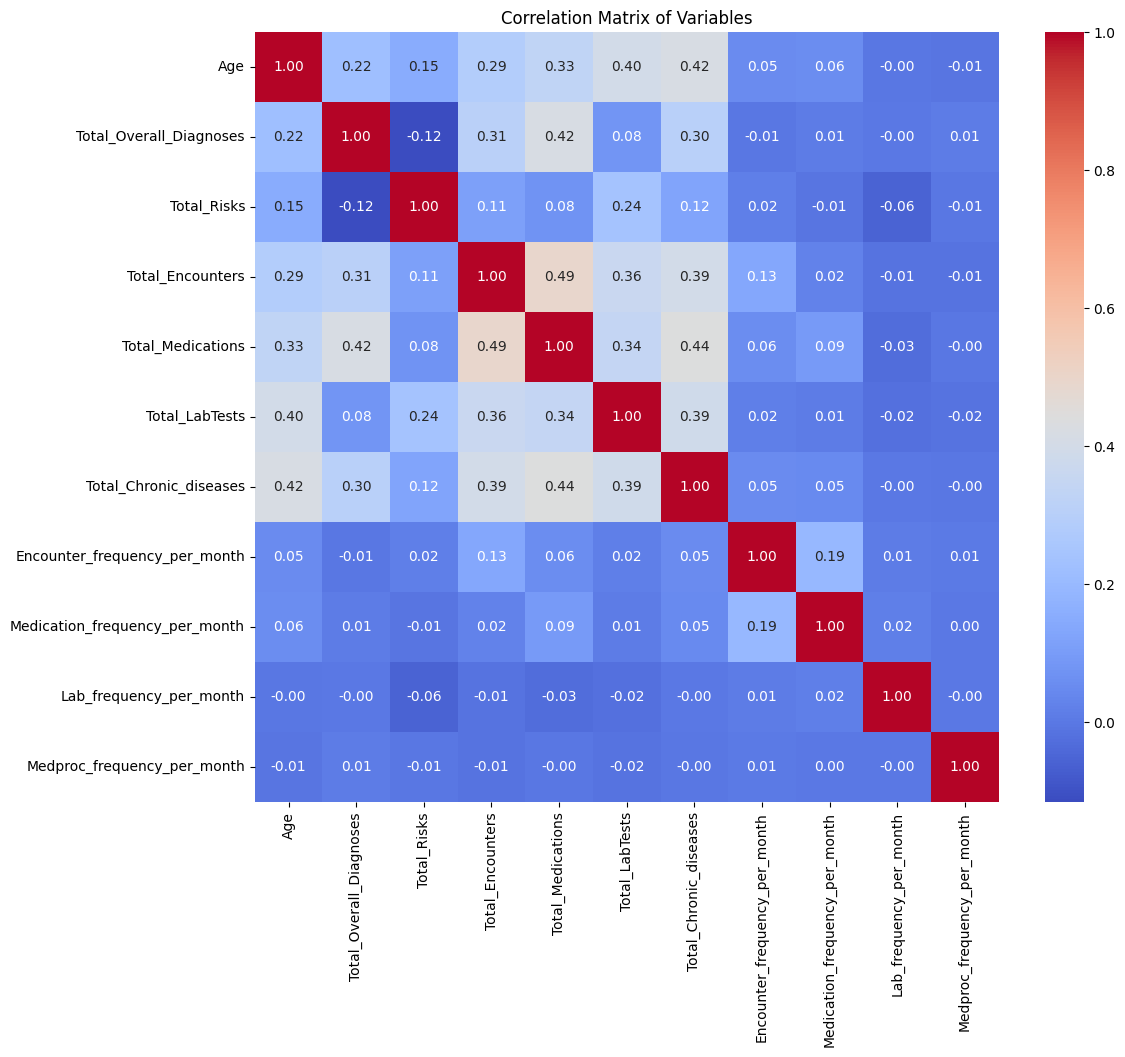

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_df = test_df[['Age', 'Total_Overall_Diagnoses', 'Total_Risks', 'Total_Encounters', 'Total_Medications', 'Total_LabTests', 'Total_Chronic_diseases', 'Encounter_frequency_per_month', 'Medication_frequency_per_month', 'Lab_frequency_per_month', 'Medproc_frequency_per_month']].copy()

correlation_matrix = corr_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

In [11]:
import pandas as pd

def create_one_hot_encoding(df, column_name, new_df):
    """Creates one-hot encoding for a given column and adds it to a new DataFrame.
    """
    if column_name not in df.columns:
        print(f"Error: '{column_name}' column not found in the DataFrame.")
        return new_df

    all_categories = set()
    for items in df[column_name]:
        if isinstance(items, list):
            for item in items:
                all_categories.add(item)

    for category in all_categories:
        new_df[category] = df[column_name].apply(lambda x: 1 if isinstance(x, list) and category in x else 0)

    return new_df

test_df = create_one_hot_encoding(master_df, 'Risk_cleaned_List', test_df)
test_df = create_one_hot_encoding(master_df, 'Grouped_Medications_Set', test_df)


### K-NN

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = test_df.drop('MH', axis=1)
y = test_df['MH']

X = pd.get_dummies(X, columns=['Sex', 'PatientStatus_calc'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.89      0.85     52058
           1       0.58      0.42      0.49     18375

    accuracy                           0.77     70433
   macro avg       0.70      0.66      0.67     70433
weighted avg       0.75      0.77      0.76     70433

[[46376  5682]
 [10574  7801]]


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [5, 10, 20, 30, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
best_knn.fit(X_train,y_train)

y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Score: 0.4810549501937776
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     52058
           1       0.58      0.42      0.49     18375

    accuracy                           0.77     70433
   macro avg       0.70      0.66      0.67     70433
weighted avg       0.75      0.77      0.76     70433

[[46376  5682]
 [10574  7801]]


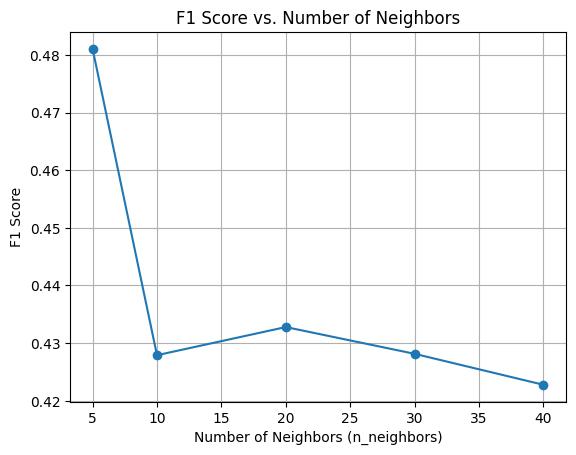

In [15]:
import matplotlib.pyplot as plt

results = grid_search.cv_results_
n_neighbors_values = results['param_n_neighbors']
f1_scores = results['mean_test_score']

plt.plot(n_neighbors_values, f1_scores, marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Neighbors')
plt.grid(True)
plt.show()

### Logistic Regression

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = test_df.drop('MH', axis=1)
y = test_df['MH']

X = pd.get_dummies(X, columns=['Sex', 'PatientStatus_calc'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     52058
           1       0.70      0.37      0.49     18375

    accuracy                           0.79     70433
   macro avg       0.75      0.66      0.68     70433
weighted avg       0.78      0.79      0.77     70433

[[49123  2935]
 [11542  6833]]


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.48841747802455043
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     52058
           1       0.70      0.37      0.49     18375

    accuracy                           0.79     70433
   macro avg       0.75      0.66      0.68     70433
weighted avg       0.78      0.79      0.77     70433

[[49119  2939]
 [11535  6840]]


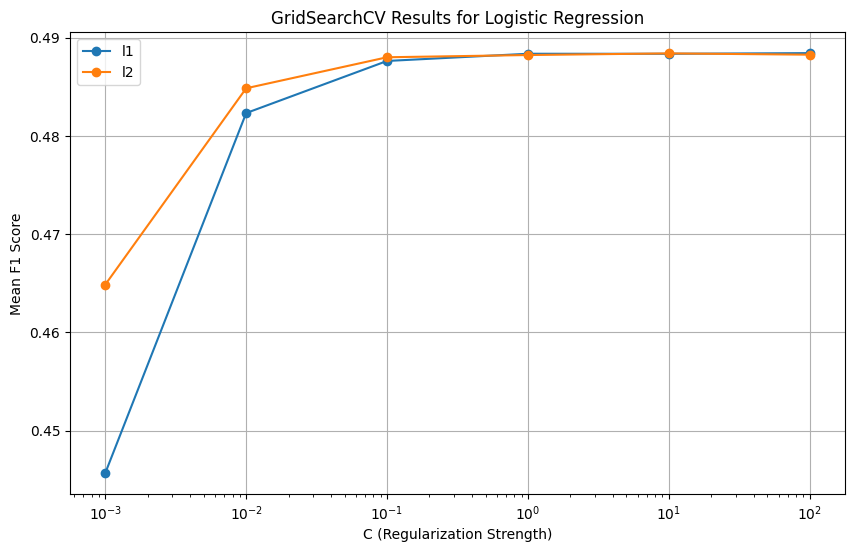

In [18]:
import matplotlib.pyplot as plt

results = grid_search.cv_results_

mean_test_scores = results['mean_test_score']
params = results['params']

c_values = []
penalty_types = []
scores = []

for i in range(len(params)):
    c_values.append(params[i]['C'])
    penalty_types.append(params[i]['penalty'])
    scores.append(mean_test_scores[i])

plt.figure(figsize=(10, 6))
for penalty in set(penalty_types):
    indices = [i for i, x in enumerate(penalty_types) if x == penalty]
    plt.plot([c_values[i] for i in indices], [scores[i] for i in indices], marker='o', label=penalty)

plt.xscale('log') # Use log scale for the x-axis (C values)
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean F1 Score')
plt.title('GridSearchCV Results for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


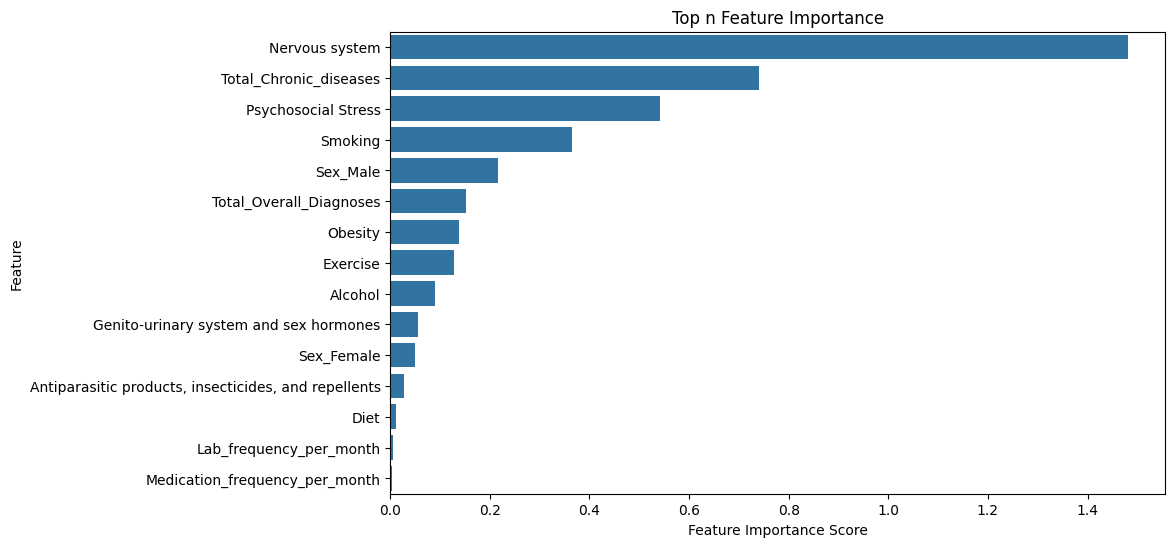

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feature_importances = best_logreg.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top n features
top_n_features = feature_importance_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_n_features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top n Feature Importance')
plt.show()


### Naive Bayes

In [ ]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB

X = test_df.drop('MH', axis=1)
y = test_df['MH']

X = pd.get_dummies(X, columns=['Sex', 'PatientStatus_calc'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81     52058
           1       0.44      0.40      0.42     18375

    accuracy                           0.71     70433
   macro avg       0.62      0.61      0.62     70433
weighted avg       0.70      0.71      0.71     70433

[[42680  9378]
 [10937  7438]]


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=20)
}

grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=5, n_jobs=-1, scoring='f1')
grid_search_nb.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_nb.best_params_)
print("Best Score:", grid_search_nb.best_score_)

best_nb = grid_search_nb.best_estimator_
best_nb.fit(X_train, y_train)

y_pred_nb = best_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'var_smoothing': np.float64(1e-09)}
Best Score: 0.44756559669878804
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     52058
           1       0.46      0.42      0.44     18375

    accuracy                           0.72     70433
   macro avg       0.63      0.62      0.63     70433
weighted avg       0.71      0.72      0.72     70433

[[42936  9122]
 [10600  7775]]
